# Reaction-diffusion models of biological invasions (Fisher KPP, heterogeneous domain & covariates, PINNs and SPINNs)

$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x)=D\Delta u(t,x) + u(t,x)(r(x) - \gamma u(t,x)), t\geq 0, x\in [0, 1]^2\\
\frac{\partial u(t,x)}{\partial n}\Big|_{x\in\partial\Omega}=\nabla u(t,x)\cdot n=0, t\geq0,\text{Neumann condition},\\
u(0,x)=u_0(x),x\in [0,1]^2
\end{cases}
$$

In all that follows,$\gamma$ et $D$ are considered known constant but $r(x)$ is a unknown varying constant.

This notebook is inspired from [_Parameter estimation for reaction-diffusion models of biological invasions_](https://link.springer.com/article/10.1007/s10144-013-0415-0) by Soubeyrand and Roques, 2014. It contains $3$ sections:

1) General set up
2) PINN solving with RAR sampling and spatially heterogeneous $r$ parameter
3) PINN solving with RAR sampling and spatially heterogeneous $r$ parameter using covariates
4) SPINN solving
5) Conclusion (Speed avantage for the SPINNs!)

## 1) Imports and general set up

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable


Import our package

In [3]:
import jinns


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial

import matplotlib.pyplot as plt

key = random.PRNGKey(2)


Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [5]:
eqx_list = [
    [eqx.nn.Linear, 3, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 1],
    [jax.nn.softplus]
]
key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 2)


In [6]:
init_nn_params = u.init_params()


Create a DataGenerator object

In [7]:
n = 600
nb = 200
nt = 600
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 20
dim = 2
xmin = 0
xmax = 1
ymin = 0
ymax = 1
tmin = 0
tmax = 1
method = "uniform"

rar_parameters = {
    'start_iter':1000, # the gradient step at which RAR algo starts (enables a burn in period)
    'update_every': 1000, # nb of gradient steps between two RAR procedures
    'sample_size_times': 22, # the number of new candidates time points
    'selected_sample_size_times': 5, # the number of selected times collocation points from the sample, to join the dataset.
    'sample_size_omega': 22, # the number of new candidates space points
    'selected_sample_size_omega': 5,
}
n_start  = 400 # the initial number of spatial collocation points at beginning
nt_start = 400 # the initial number of temporal collocation points at beginning

Tmax = 2
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin, ymin),
    (xmax, ymax),
    tmin,
    tmax,
    method,
    rar_parameters=rar_parameters,
    n_start=n_start,
    nt_start=nt_start
)

## Set up the initial condition

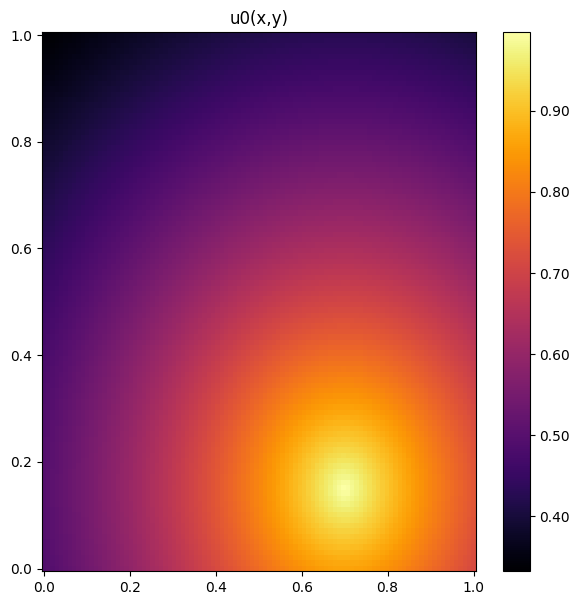

In [8]:
from jax.scipy.stats import norm
sigma_init = 1 * jnp.ones((2))
mu_init = jnp.array([0.7, 0.15])

def u0(x):
    return jnp.exp(-jnp.linalg.norm(x - mu_init))

nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

jinns.data.plot2d(
    fun=u0,
    xy_data=val_xy_data,
    title="u0(x,y)"
)


## 1) Spatial heterogeneity of $r$

### True model parameters

We need to load the matrix containing the r values

In [9]:
D = 0.05
g = 1.
r1, r2, r3 = 0., -4., 2.


A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary

In [10]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "D":jnp.array([D]),
        "r":jnp.array([r1, r2, r3]),
        "g":jnp.array([g])
    }
}


The spatial heterogeneity of $r$ is introduced through a user defined function which recreates the spatial map

In [11]:
def r_fun(t, x, _, params):
    """ must be a jittable function """
    eq_params = params["eq_params"]
    r1, r2, r3 = eq_params["r"]
    return jax.lax.switch(
        jnp.amax(
            jnp.nonzero(
                jnp.array([
                    True,
                    jnp.logical_or(
                        jnp.logical_and(x[0] > 6 / 20, x[0] < 8 / 20),
                        jnp.logical_and(x[1] > 8 / 20, x[1] < 10 / 20)
                    ),
                    jnp.logical_or(
                        (x[0] - 0.15)**2 + (x[1] - 0.15)**2 < 0.015,
                        (x[0] - 0.8)**2 + (x[1] - 0.80)**2 < 0.03
                    )
                ]),
                size=3
            )[0]
        ),
        [lambda _:r1, lambda _:r2, lambda _:r3],
        ()
    )


Let's visualize the spatial heterogeneity map that we have just created:

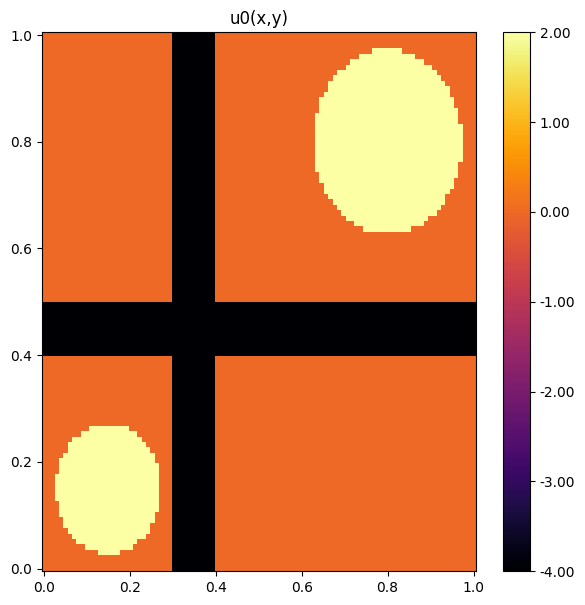

In [12]:
nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

jinns.data.plot2d(
    fun=lambda x: r_fun(None, x, None, init_params),
    xy_data=val_xy_data,
    title="u0(x,y)"
)


### Loss construction
Create the Reaction Diffusion 2D loss. The loss contains **heterogeneous parameters** that can be managed in two steps:

1. Define a dictionary `eq_params_heterogeneity` with any kind of functions that should be applied to the equation parameters. Here, the $r$ coefficient is varies spatially according to the `r_fun` defined above. Note that whatever the transform, the arguments of the such a function must be `t, x, u, params` in the stationary case.

2. Transform the parameters according to the content of the dictionary `eq_params_heterogeneity` at each call of `evaluate`. This can be done simply by decorating the `evaluate()` method with `@evaluate_heterogeneous_parameters` (since we use a predefined dynamic loss, the decorator is already set; check out the FisherKPP loss class in `jinns/loss/_DynamicLoss.py`). The equivalent code of such decorator would be:
```
params["eq_params"] = self.eval_heterogeneous_parameters(
     t, x, u, params, self.eq_params_heterogeneity)
```

In [13]:
fisher_dynamic_loss = jinns.loss.FisherKPP(
    Tmax=Tmax,
    eq_params_heterogeneity={"D":None, "r":r_fun, "g":None}
)


In [14]:
loss_weights = {"dyn_loss":1, "initial_condition": 1 * Tmax, "boundary_loss":1 * Tmax}

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="neumann",
    initial_condition_fun=u0,
    norm_key=None,
    norm_borders=None,
    norm_samples=None
)


In [15]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    train_data.get_batch()
)


l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")


total loss: 9.127065658569336
Individual losses: {'boundary_loss': '0.76', 'dyn_loss': '8.31', 'initial_condition': '0.05', 'norm_loss': '0.00', 'observations': '0.00', 'sobolev': '0.00'}


### Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [16]:
params = init_params


In [17]:
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-3)


In [18]:
n_iter = 50000


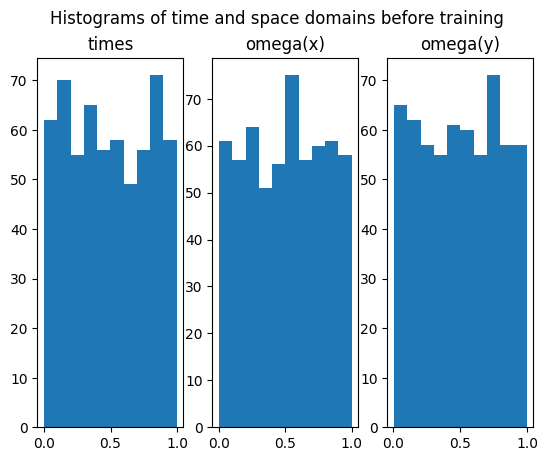

In [19]:
fig, ax = plt.subplots(1, 3)
ax[0].hist(train_data.times)
ax[0].set_title('times')
ax[1].hist(train_data.omega[:, 0].flatten())
ax[1].set_title('omega(x)')
ax[2].hist(train_data.omega[:, 1].flatten())
ax[2].set_title('omega(y)')
fig.suptitle('Histograms of time and space domains before training')
plt.show()

In [20]:
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
)


[train] Iteration 0: loss value = 7.245938777923584
[train] Iteration 1000: loss value = 0.41911351680755615
[train] Iteration 2000: loss value = 0.44403988122940063
[train] Iteration 3000: loss value = 0.4819207191467285
[train] Iteration 4000: loss value = 0.5127325654029846
[train] Iteration 5000: loss value = 0.4820302128791809
[train] Iteration 6000: loss value = 0.5383639931678772
[train] Iteration 7000: loss value = 0.486149400472641
[train] Iteration 8000: loss value = 0.5170255303382874
[train] Iteration 9000: loss value = 0.49201759696006775
[train] Iteration 10000: loss value = 0.6240872144699097
[train] Iteration 11000: loss value = 0.6207857131958008
[train] Iteration 12000: loss value = 0.49677374958992004
[train] Iteration 13000: loss value = 0.5298173427581787
[train] Iteration 14000: loss value = 0.4878119230270386
[train] Iteration 15000: loss value = 0.47339701652526855
[train] Iteration 16000: loss value = 0.4556729197502136
[train] Iteration 17000: loss value = 0.5

### Results

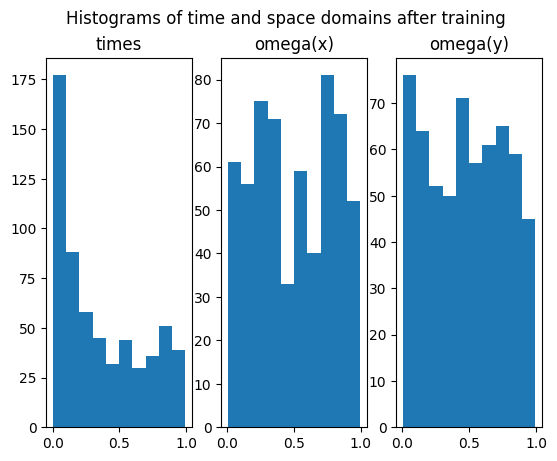

In [21]:
fig, ax = plt.subplots(1, 3)
ax[0].hist(train_data.times)
ax[0].set_title('times')
ax[1].hist(train_data.omega[:, 0].flatten())
ax[1].set_title('omega(x)')
ax[2].hist(train_data.omega[:, 1].flatten())
ax[2].set_title('omega(y)')
fig.suptitle('Histograms of time and space domains after training')
plt.show()


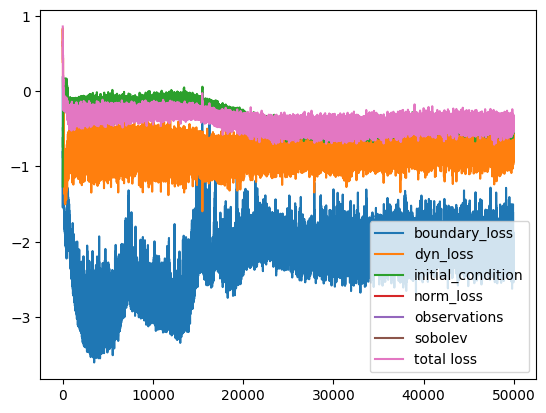

In [22]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();


Plot the PDE solution learned by the PINN

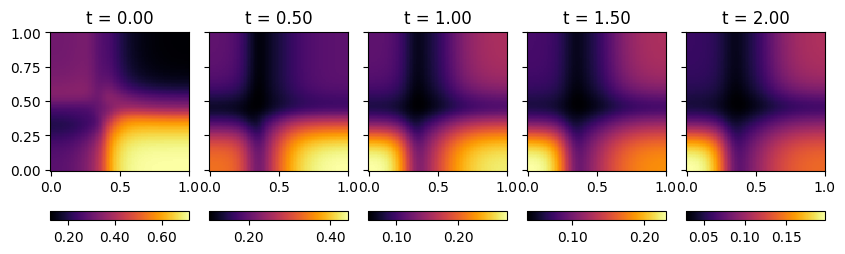

In [23]:
times = [0, 0.25, 0.5, 0.75, 1] # times in the rescaled time susescale
u_est = lambda t, x: u(t, x, params)
jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(10, 10*len(times))
)


## 2) Spatial heterogeinity of $r$ through a GLM 

This section is inspired from mechanico-statistical model in ecology as e.g.
 [this article](https://www.sciencedirect.com/science/article/pii/S2211675320300221?via%3Dihub) 
 and [accompanying code](https://github.com/oliviergimenez/appendix_mecastat/blob/01a89e8d2506849b28ec9da6fa7dec0a3be61050/mecastat_simulations.R#L127)). 

Let us say that we have access to an addition spatial covariate, $c(x)$ 
which corresponds to forest covering at position $x$. We make the hypothesis 
that the reproduction rate $r(x)$ spatially depends on $c(x)$ through the 
following logistic link
$$
  r(x) = \frac{1}{1 + e^{\beta_0 + \beta_1 c(x) + \beta_2 c(x)^2}}
$$

Here, $\beta$ is supposed known and fixed but one could optimize w.r.t to 
$\beta$ in inverse problem settings.

In [24]:
D = 0.05
g = 1.
r0 = 0.

init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "D":jnp.array([D]),
        "r":jnp.array([r0]),
        "g":jnp.array([g]),
        "beta":jnp.array([-2., 1., 5.])
    }
}


We now specify how we get the covariate value at point $x$. Here, we say say the covariate is accessible everywhere and disposed on a map (for simplicity we take the same as before).

In [25]:
def covariate(x):
    """ must be a jittable function """
    f1, f2, f3 = 0.5, 0.0, 0.9
    return jax.lax.switch(
        jnp.amax(
            jnp.nonzero(
                jnp.array([
                    True,
                    jnp.logical_or(
                        jnp.logical_and(x[0] > 6 / 20, x[0] < 8 / 20),
                        jnp.logical_and(x[1] > 8 / 20, x[1] < 10 / 20)
                    ),
                    jnp.logical_or(
                        (x[0] - 0.15)**2 + (x[1] - 0.15)**2 < 0.015,
                        (x[0] - 0.8)**2 + (x[1] - 0.80)**2 < 0.03
                    )
                ]),
                size=3
            )[0]
        ),
        [lambda _:f1, lambda _:f2, lambda _:f3],
        ()
    )


In [26]:
def r_fun(t, x, _, params):
    """ must be a jittable function """
    # t is never used here since no temporal modeling
    # but we could have covariate(t, x) in a non-stationary setting
    c = covariate(x)
    return jax.nn.sigmoid(jnp.sum(params["eq_params"]["beta"] * jnp.array([1, c, c ** 2])))


Text(0.5, 1.0, 'Generalized linear model: $b(r) = \\beta^\\top (1, c, c^2)$.')

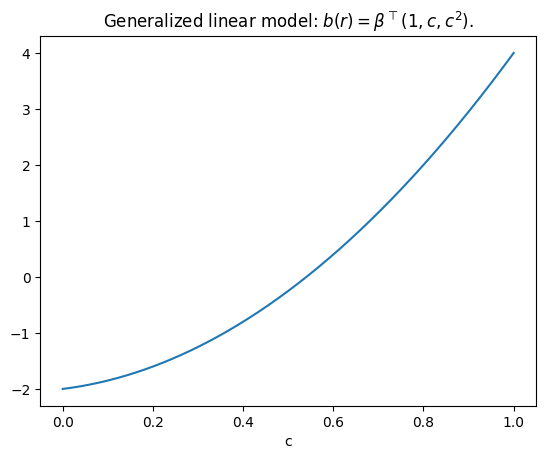

In [27]:
cs = jnp.linspace(0, 1, 1000)
plt.plot(cs, vmap(lambda c: jnp.sum(init_params["eq_params"]["beta"] * jnp.array([1, c, c ** 2])))(cs))
plt.xlabel(r"c")
plt.title(r"Generalized linear model: $b(r) = \beta^\top (1, c, c^2)$.")


Let's visualize the growth rate that is obtained throught this link:

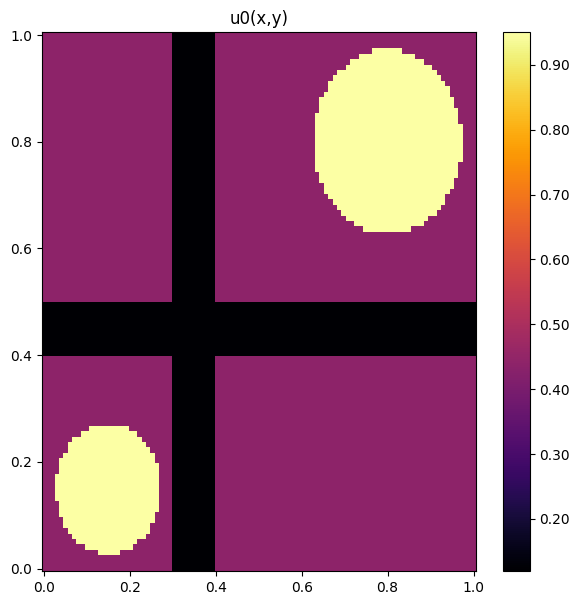

In [28]:
nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]


jinns.data.plot2d(
    fun=lambda x: r_fun(None, x, None, init_params),
    xy_data=val_xy_data,
    title="u0(x,y)"
)


Then the rest follows as in the previous section

In [29]:
fisher_dynamic_loss = jinns.loss.FisherKPP(
    Tmax=Tmax,
    eq_params_heterogeneity={"D":None, "r":r_fun, "g":None}
)


In [30]:
# recreate train_data because rar_sampling was previously used on another
# problem => reset the collocation points
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin, ymin),
    (xmax, ymax),
    tmin,
    tmax,
    method,
)

In [31]:
loss_weights = {"dyn_loss":10, "initial_condition": 1 * Tmax, "boundary_loss":1 * Tmax}

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="neumann",
    initial_condition_fun=u0,
    norm_key=None,
    norm_borders=None,
    norm_samples=None
)


In [32]:
params = init_params
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-3)
n_iter = 50000

params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
)


[train] Iteration 0: loss value = 1.798025131225586
[train] Iteration 1000: loss value = 0.5542744398117065
[train] Iteration 2000: loss value = 0.5217065811157227
[train] Iteration 3000: loss value = 0.5165632963180542
[train] Iteration 4000: loss value = 0.5438879728317261
[train] Iteration 5000: loss value = 0.4533853828907013
[train] Iteration 6000: loss value = 0.5636283159255981
[train] Iteration 7000: loss value = 0.5694667100906372
[train] Iteration 8000: loss value = 0.49446743726730347
[train] Iteration 9000: loss value = 0.41161221265792847
[train] Iteration 10000: loss value = 0.39522016048431396
[train] Iteration 11000: loss value = 0.4757661819458008
[train] Iteration 12000: loss value = 0.37031856179237366
[train] Iteration 13000: loss value = 0.3503568470478058
[train] Iteration 14000: loss value = 0.22053465247154236
[train] Iteration 15000: loss value = 0.21482005715370178
[train] Iteration 16000: loss value = 0.15990954637527466
[train] Iteration 17000: loss value = 

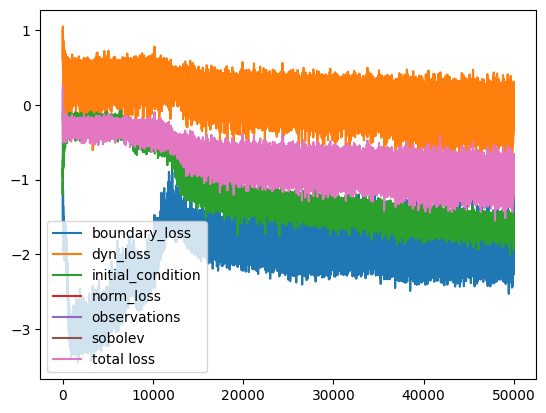

In [33]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();


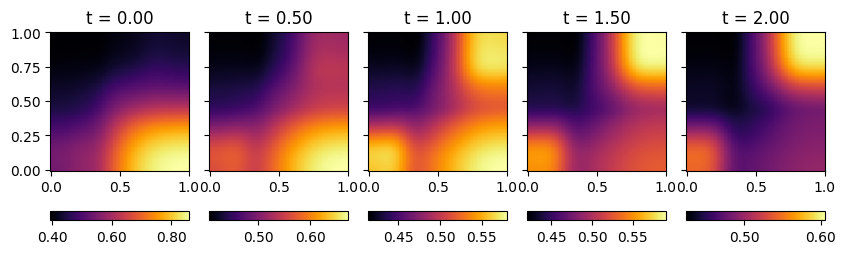

In [34]:
times = [0, 0.25, 0.5, 0.75, 1] # times in the rescaled time susescale
u_est = lambda t, x: u(t, x, params)
jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(10, 10*len(times))
)


## 3) Separable PINNs
In this section, we run experiments in the same context but with [Separable PINNs](https://openreview.net/pdf?id=dEySGIcDnI).

In [35]:
d = 3
r = 256
eqx_list = [
    [eqx.nn.Linear, 1, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, r],
]
key, subkey = random.split(key)
u_spinn = jinns.utils.create_SPINN(subkey, d, r, eqx_list, "nonstatio_PDE")
init_nn_params_spinn = u_spinn.init_params()

# Reset train_data: here we do not use RAR sampling as it is not implemented
# for separable-PINNs
n = 600
nb = 600
nt = 600
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 32
dim = 2
xmin = 0
xmax = 1
ymin = 0
ymax = 1
tmin = 0
tmax = 1
method = "uniform"

Tmax = 2
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin, ymin),
    (xmax, ymax),
    tmin,
    tmax,
    method,
)

### Set up the initial condition

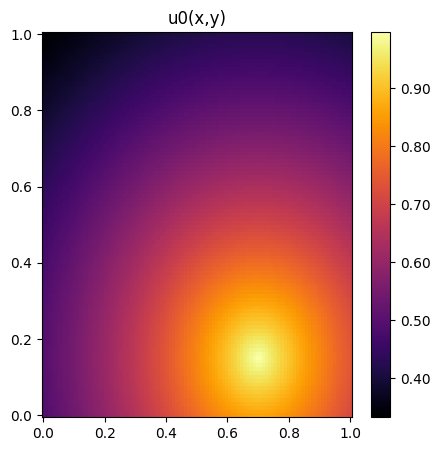

In [36]:
from jax.scipy.stats import norm
sigma_init = 1 * jnp.ones((2))
mu_init = jnp.array([0.7, 0.15])

def u0(x):
    return jnp.exp(-jnp.linalg.norm(x - mu_init, axis=-1))

nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

jinns.data.plot2d(
    fun=u0,
    xy_data=val_xy_data,
    title="u0(x,y)",
    figsize=(5, 5)
)

### Define the parameters and the spatial heterogeneity of $r$

In [37]:
D = 0.05
g = 1.
r1, r2, r3 = 0., -4., 2.

In [38]:
init_params = {
    "nn_params":init_nn_params_spinn,
    "eq_params":{
        "D":jnp.array([D]),
        "r":jnp.array([r1, r2, r3]),
        "g":jnp.array([g])
    }
}

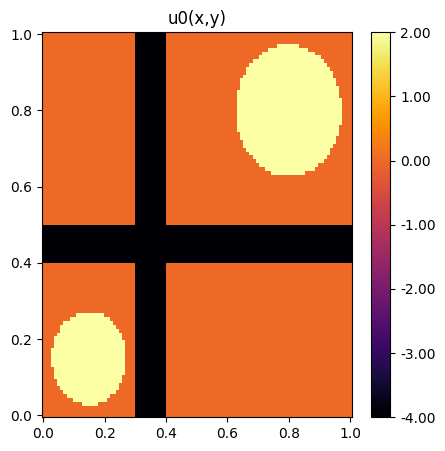

In [39]:
from jinns.utils._utils import _get_grid

def r_fun(t, x, _, params):
    """ must be a jittable function """
    x = _get_grid(x.squeeze())
    eq_params = params["eq_params"]
    r1, r2, r3 = eq_params["r"]

    # # Next is required to be able to call plot_2D and see the map
    # if x.shape[0] != x.shape[1]:
    #     x = _get_grid(x.squeeze())

    # By default put r1 everywhere
    r_map_batch = jnp.full(x.shape[:2], r1)
    # But if the next cond is True, update to r2
    r_map_batch = jnp.where(
        jnp.logical_or(
            jnp.logical_and(x[..., 0] > 6 / 20, x[..., 0] < 8 / 20),
            jnp.logical_and(x[..., 1] > 8 / 20, x[..., 1] < 10 / 20)
        ),
        r2,
        r_map_batch
    )
    # Again if the next cond is True, update to r3
    r_map_batch = jnp.where(
        jnp.logical_or(
                        (x[..., 0] - 0.15)**2 + (x[..., 1] - 0.15)**2 < 0.015,
                        (x[..., 0] - 0.8)**2 + (x[..., 1] - 0.80)**2 < 0.03
        ),
        r3,
        r_map_batch
    )
    return r_map_batch

nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

jinns.data.plot2d(
    fun=lambda x: r_fun(None, x, None, init_params),
    xy_data=val_xy_data,
    title="u0(x,y)",
    spinn=True,
    figsize=(5, 5)
)

### Construct the loss

In [40]:
fisher_dynamic_loss = jinns.loss.FisherKPP(
    Tmax=Tmax,
    eq_params_heterogeneity={"D":None, "r":r_fun, "g":None}
)
loss_weights = {"dyn_loss":1, "initial_condition": 1 * Tmax, "boundary_loss":1 * Tmax}

loss = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="neumann",
    initial_condition_fun=u0,
    norm_key=None,
    norm_borders=None,
    norm_samples=None
)

### Learning

In [41]:
params = init_params
import optax
tx = optax.adamw(learning_rate=1e-3)
n_iter = 2500
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
)

[train] Iteration 0: loss value = 0.7608334422111511
[train] Iteration 1000: loss value = 0.15697504580020905
[train] Iteration 2000: loss value = 0.28355419635772705
Stopping main optimization loop, cause: max iteration is reached
Final iteration 2500: train loss value = 0.1504487246274948


### Results

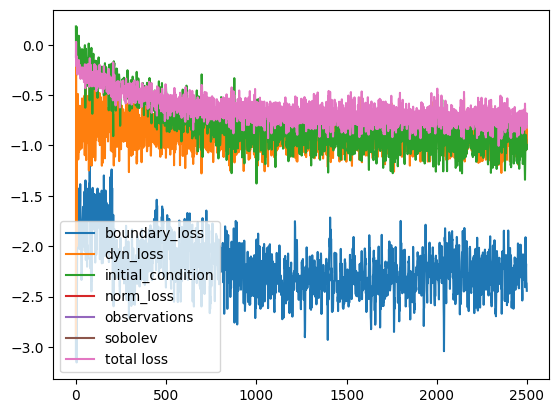

In [42]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

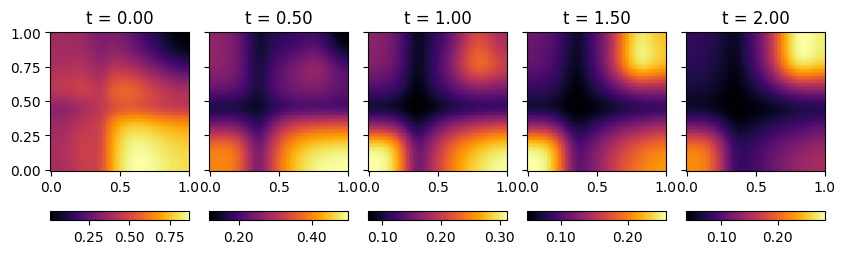

In [43]:
times = [0, 0.25, 0.5, 0.75, 1] # times in the rescaled time susescale
u_est = lambda t, x: u_spinn(t, x, params)
jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    figsize=(10, 10*len(times)),
    spinn=True
)

### Solving for different initial conditions

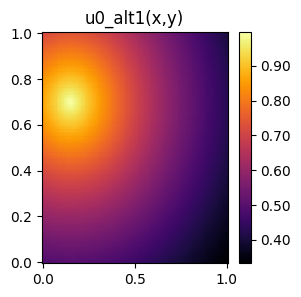

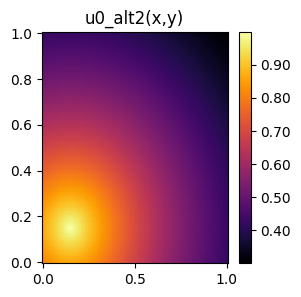

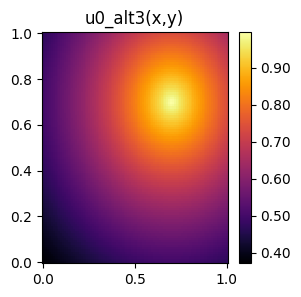

In [44]:
from jax.scipy.stats import norm
def u0_alt1(x):
    return jnp.exp(-jnp.linalg.norm(x - jnp.array([0.15, 0.7]), axis=-1))
jinns.data.plot2d(
    fun=u0_alt1,
    xy_data=val_xy_data,
    title="u0_alt1(x,y)",
    figsize=(3, 3)
)
def u0_alt2(x):
    return jnp.exp(-jnp.linalg.norm(x - jnp.array([0.15, 0.15]), axis=-1))
jinns.data.plot2d(
    fun=u0_alt2,
    xy_data=val_xy_data,
    title="u0_alt2(x,y)",
    figsize=(3, 3)
)
def u0_alt3(x):
    return jnp.exp(-jnp.linalg.norm(x - jnp.array([0.7, 0.7]), axis=-1))
jinns.data.plot2d(
    fun=u0_alt3,
    xy_data=val_xy_data,
    title="u0_alt3(x,y)",
    figsize=(3, 3)
)

[train] Iteration 0: loss value = 0.8742077946662903
[train] Iteration 1000: loss value = 0.19097790122032166
[train] Iteration 2000: loss value = 0.18981724977493286
Stopping main optimization loop, cause: max iteration is reached
Final iteration 2500: train loss value = 0.2357577234506607


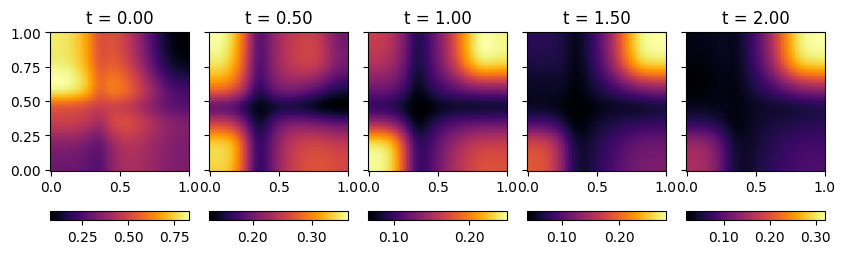

In [45]:
loss = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="neumann",
    initial_condition_fun=u0_alt1,
)
params = init_params
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
)
u_est = lambda t, x: u_spinn(t, x, params)
jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    figsize=(10, 10*len(times)),
    spinn=True
)

[train] Iteration 0: loss value = 0.6723214983940125
[train] Iteration 1000: loss value = 0.20471200346946716
[train] Iteration 2000: loss value = 0.21293747425079346
Stopping main optimization loop, cause: max iteration is reached
Final iteration 2500: train loss value = 0.14195087552070618


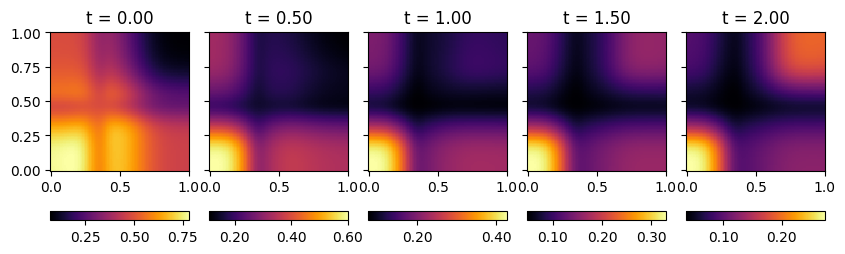

In [46]:
loss = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="neumann",
    initial_condition_fun=u0_alt2,
)
params = init_params
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
)
u_est = lambda t, x: u_spinn(t, x, params)
jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    figsize=(10, 10*len(times)),
    spinn=True
)

[train] Iteration 0: loss value = 0.9171435236930847
[train] Iteration 1000: loss value = 0.32756859064102173
[train] Iteration 2000: loss value = 0.26778483390808105
Stopping main optimization loop, cause: max iteration is reached
Final iteration 2500: train loss value = 0.20642909407615662


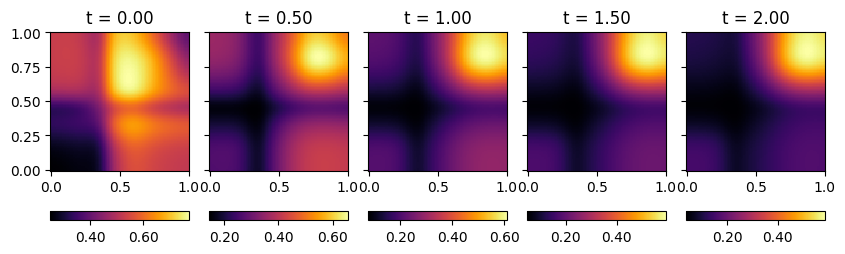

In [47]:
loss = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="neumann",
    initial_condition_fun=u0_alt3,
)
loss.initial_condition_fun = u0_alt3
params = init_params
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
)
u_est = lambda t, x: u_spinn(t, x, params)
jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    figsize=(10, 10*len(times)),
    spinn=True
)

## 5) Conclusion

We have solved this Fisher KPP PDE tackling parameter heterogeneity and with both the PINN and SPINN approaches. Both approaches seem to converge quite efficiently towards the solution but a speed advantage goes towards the SPINNs (given batches of the same sizes and total number of collocation points -up to the few points added in RAR-). Note that SPINNs require less iterations to reach convergence. We report the progress bars for each learning part:

- PINN Section 2: 50000/50000 [01:54<00:00, 438.53it/s]
- PINN Section 3: 50000/50000 [01:54<00:00, 437.55it/s]
- SPINNs Section 4:  2500/2500 [00:17<00:00, 144.29it/s],  2500/2500 [00:17<00:00, 143.65it/s], 2500/2500 [00:17<00:00, 143.41it/s] and 2500/2500 [00:17<00:00, 143.95it/s]

(Times obtained on GPU Nvidia T600)